<a href="https://colab.research.google.com/github/akash99955/AML/blob/main/AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# ==============================================================================
# Step 1: Install and Import Necessary Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import re
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder # Needed if models cannot handle string labels directly (good practice)

# To ensure consistent and reproducible results
np.random.seed(42)

# Dictionary to store results for comparison
results = {}

In [7]:
# ==============================================================================
# Step 2: Data Loading and Preprocessing (Cleaning & Encoding)
# ==============================================================================

# NOTE: The script assumes 'Tweets.csv' is accessible in the working directory.
try:
    # Use the filename provided by the user
    data = pd.read_csv('/content/Tweets.csv')
    print("Data loaded successfully. Total tweets:", len(data))
except FileNotFoundError:
    print("Error: 'Tweets.csv' not found. Please ensure the file is in the correct directory.")
    # Instead of exit(), re-raise the error or raise a custom one to stop execution gracefully in Colab
    raise FileNotFoundError("Data file 'Tweets.csv' not found. Please upload it or check the path.")

def clean_text(text):
    """
    Cleans tweet text by removing URLs, mentions, and basic noise.
    """
    text = text.lower()
    # 1. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 2. Remove user mentions (@names)
    text = re.sub(r'@\w+', '', text)
    # 3. Remove non-alphabet characters (keeping spaces)
    text = re.sub(r'[^a-z\s]', ' ', text)
    # 4. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the cleaning function to the 'text' column
data['cleaned_review'] = data['text'].apply(clean_text)

# Define X (features) and y (target)
X = data['cleaned_review']
y = data['airline_sentiment']

# Define the unique class names for consistent plotting and reporting
class_names = sorted(y.unique().tolist()) # ['negative', 'neutral', 'positive']

# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Data loaded successfully. Total tweets: 9155


In [8]:
# ==============================================================================
# Step 3: Feature Extraction (TF-IDF Vectorization)
# ==============================================================================

print("\n--- Feature Extraction ---")
# Initialize and fit TF-IDF Vectorizer
# Using bigrams (ngram_range=(1, 2)) often captures more context
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2))

# Fit the vectorizer on the training data and transform both train and test sets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training Samples: {len(X_train)} | TF-IDF Matrix Size: {X_train_tfidf.shape}")


--- Feature Extraction ---
Training Samples: 7324 | TF-IDF Matrix Size: (7324, 10000)


In [9]:
# ==============================================================================
# Step 4: Model Training and Evaluation Function
# ==============================================================================

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, class_names):
    """Trains a model, evaluates it, and stores the results."""

    start_time = time()
    print(f"\n--- Training {model_name} ---")
    model.fit(X_train, y_train)
    training_time = time() - start_time
    print(f"{model_name} trained in {training_time:.2f} seconds.")

    # Prediction
    y_pred = model.predict(X_test)

    # Evaluation Metrics (Weighted Average F1 is best for comparison)
    accuracy = accuracy_score(y_test, y_pred)
    # Use labels=class_names to ensure consistent order for reporting
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', labels=class_names)

    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Training Time (s)': training_time,
        'y_pred': y_pred
    }

    # Print required reports
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

    return y_pred

In [10]:
# ==============================================================================
# Step 5: Execute Model Training and Evaluation for All Algorithms
# ==============================================================================

# --- Model 1: Logistic Regression ---
lr_model = LogisticRegression(solver='liblinear', random_state=42, C=1.0, max_iter=1000)
y_pred_lr = train_and_evaluate_model(lr_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "Logistic Regression", class_names)

# --- Model 2: Multinomial Naive Bayes ---
mnb_model = MultinomialNB()
y_pred_mnb = train_and_evaluate_model(mnb_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "Multinomial Naive Bayes", class_names)

# --- Model 3: Random Forest Classifier ---
# Note: This model is generally slow and less effective on sparse text data than LR/MNB.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
y_pred_rf = train_and_evaluate_model(rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "Random Forest", class_names)


--- Training Logistic Regression ---
Logistic Regression trained in 1.20 seconds.
Accuracy: 0.7253

Classification Report:
               precision    recall  f1-score   support

    negative       0.72      0.93      0.81      1017
     neutral       0.70      0.42      0.53       459
    positive       0.79      0.52      0.63       355

    accuracy                           0.73      1831
   macro avg       0.74      0.63      0.66      1831
weighted avg       0.73      0.73      0.71      1831


--- Training Multinomial Naive Bayes ---
Multinomial Naive Bayes trained in 0.07 seconds.
Accuracy: 0.6663

Classification Report:
               precision    recall  f1-score   support

    negative       0.64      0.98      0.78      1017
     neutral       0.75      0.25      0.38       459
    positive       0.85      0.30      0.44       355

    accuracy                           0.67      1831
   macro avg       0.75      0.51      0.53      1831
weighted avg       0.71      0.67  


FINAL ALGORITHM PERFORMANCE COMPARISON (ACCURACY & F1-SCORE)
|                         |   Accuracy |   F1-Score |   Precision |   Recall |   Training Time (s) |
|:------------------------|-----------:|-----------:|------------:|---------:|--------------------:|
| Logistic Regression     |     0.7253 |     0.7052 |      0.7289 |   0.7253 |              1.1976 |
| Random Forest           |     0.7084 |     0.7015 |      0.7018 |   0.7084 |             17.4468 |
| Multinomial Naive Bayes |     0.6663 |     0.6121 |      0.7105 |   0.6663 |              0.066  |


/tmp/ipython-input-2760285507.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_plot, y=f1_scores_plot, palette='viridis')


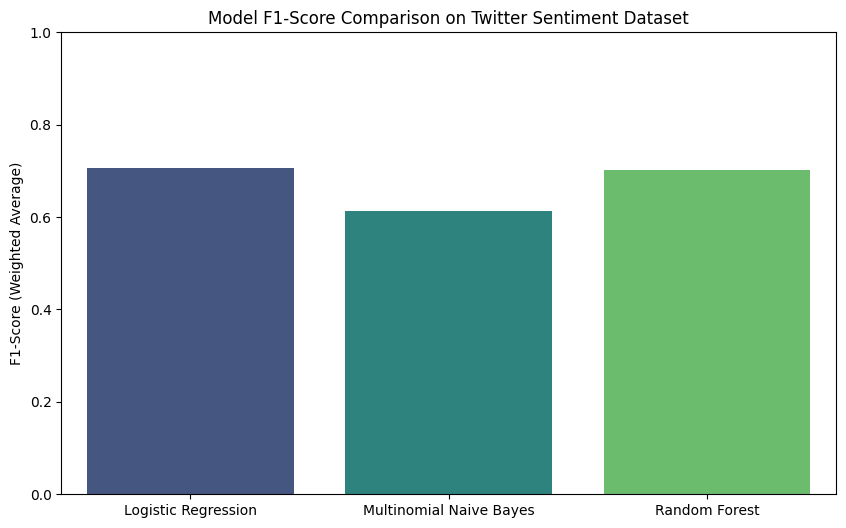

In [11]:
# ==============================================================================
# Step 6: Comparison of Algorithms (Required for Milestone 2)
# ==============================================================================

# Convert results dictionary to a DataFrame for easy viewing
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df_markdown = results_df.drop(columns=['y_pred']).sort_values(by='Accuracy', ascending=False)
results_df_markdown = results_df_markdown.apply(lambda x: x.map(lambda y: f'{y:.4f}') if x.dtype == 'float64' else x)

print("\n" + "="*60)
print("FINAL ALGORITHM PERFORMANCE COMPARISON (ACCURACY & F1-SCORE)")
print("="*60)
print(results_df_markdown.to_markdown())

# Visualize the performance
f1_scores_plot = [results[model_name]['F1-Score'] for model_name in results_df.index]
metrics_plot = results_df.index.tolist()

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_plot, y=f1_scores_plot, palette='viridis')
plt.title('Model F1-Score Comparison on Twitter Sentiment Dataset')
plt.ylabel('F1-Score (Weighted Average)')
plt.ylim(0, 1.0)
plt.savefig('f1_score_comparison.png')
plt.show() # F1 Score comparison chart


Confusion Matrix for the Best Performer: Logistic Regression


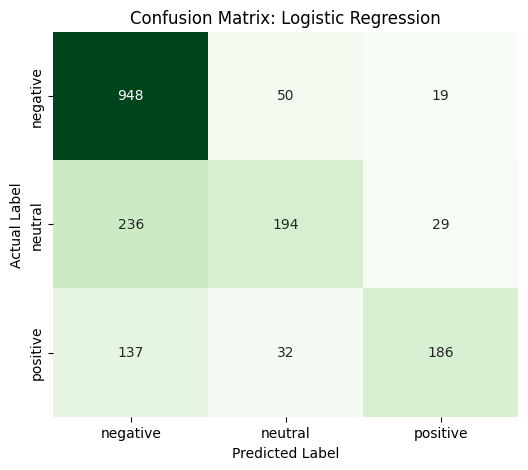

In [12]:
# ==============================================================================
# Step 7: Visualize Confusion Matrix for the Best Performer (Required Visualization)
# ==============================================================================

# Identify the best performer based on Accuracy
best_model_name = results_df.sort_values(by='Accuracy', ascending=False).index[0]
y_pred_best = results[best_model_name]['y_pred']

print(f"\nConfusion Matrix for the Best Performer: {best_model_name}")
cm = confusion_matrix(y_test, y_pred_best, labels=class_names)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix: {best_model_name}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_best.png')
plt.show() # Confusion matrix chart